# Quantifying uncertainty before running a calibration

In [1]:
# Jinko specifics imports & initialization
# Please fold this section and do not edit it
import sys

sys.path.insert(0, "../lib")
import jinko_helpers as jinko

# Connect to Jinko (see README.md for more options)
jinko.initialize()

Authentication successful


In [2]:
# Cookbook specifics imports
import io
import uuid
import json
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import qmc
import zipfile
import textwrap

## Step 0: Select calibration of interest


In [3]:
"""
Calibration short id can be retrieved from the URL of your calibration in Jinko, pattern is `https://jinko.ai/<calibration_short_id>`

WARNING: we cache the exploration trial ID such that subsequent runs of the notebook create new versions
of the same Trial instead of new Trials each time.
When CHANGING the calibration of interest, you will want to delete the cache by restarting the kernel (there should be a "Restart" or "Restart kernel" button somewhere)
"""

calibration_short_id = "ca-pckt-0FOX"

# folder ID, pattern is `https://jinko.ai/project/<project_id>?labels=<folder_id>`
# This folder is where the exploratory Vpop and Trial will be saved, it does not have to be the same folder as that of
# the initial calibration
folder_id = "a7c3c20e-cf4b-4ea4-87da-7d26953f24f0"

## Step 1: Pick the calibration version of interest

In [31]:
# Choose a specific revision. By default we return the last version
revision = 61
# Choose a specific label. By default we return the last version
label = None
response = jinko.get_project_item(
    sid=calibration_short_id, revision=revision, label=label
)
calibration_core_item_id, calibration_snapshot_id = (
    response["coreId"]["id"],
    response["coreId"]["snapshotId"],
)

# # Uncomment the following if you want to use the latest completed or stopped version
# response = jinko.get_latest_calib_with_status(shortId=calibration_short_id, statuses=["completed", "stopped"])
# calibration_core_item_id, calibration_snapshot_id = response["coreItemId"], response["snapshotId"]

print(
    f"Picked Calibration with coreItemId: {calibration_core_item_id}, snapshotId: {calibration_snapshot_id}"
)
calibration_link = jinko.get_project_item_url_from_sid(calibration_short_id)
calibration_link_with_revision = (
    f"{calibration_link}?revision={revision}" if revision else calibration_link
)
print(f"Calibration link: {calibration_link_with_revision}")

Picked Calibration with coreItemId: 8d93ea4d-58f5-4bfc-8d37-a39a04471e36, snapshotId: 76468346-e303-46dc-8ee2-4ba19a9a6d28
Calibration link: https://jinko.ai/ca-pckt-0FOX?revision=61


## Step 2: Generate the exploratory Vpop

In [32]:
# Get the list of scalars that we want to download, they correspond to the calibration objectives
objectives = jinko.make_request(
    f"/core/v2/calibration_manager/calibration/{calibration_core_item_id}/snapshots/{calibration_snapshot_id}/objectives_weights",
    method="GET",
).json()

calibration_inputs = jinko.make_request(
    f"/core/v2/calibration_manager/calibration/{calibration_core_item_id}/snapshots/{calibration_snapshot_id}",
).json()
parameters = calibration_inputs["parameters"]
print(f"parameters to calibrate: {[p['id'] for p in parameters]}")
parameter_map = {p["id"]: p for p in parameters}

parameters to calibrate: ['reflectionCoefficient', 'lymphDrainingRate', 'kClearanceDrug', 'bloodFlowRate']


In [44]:
def to_patient(x):
    return {
        "patientIndex": str(uuid.uuid4()),
        "patientCategoricalAttributes": [],
        "patientAttributes": [
            {"id": p["id"], "val": x[j]} for j, p in enumerate(parameters)
        ],
    }


# Set custom ranges and logscale here. Simply add a new entry for each parameter that needs to be tweaked
# Log scale is in base 10
custom_range = {
    "kClearanceDrug": {"logscale": True, "min": -4, "max": 0},
    "bloodFlowRate": {"logscale": True, "min": -1, "max": 2},
    "reflectionCoefficient": {"logscale": True, "min": -3, "max": 0},
}


def parameter_lower_bound(parameter):
    param_name = parameter["id"]
    if (
        param_name in custom_range.keys()
        and custom_range[param_name].get("min") is not None
    ):
        return custom_range[param_name]["min"]
    elif parameter["minBound"]:
        return parameter["minBound"]
    elif parameter["mean"] and parameter["std"]:
        return parameter["mean"] - 3 * parameter["std"]
    else:
        raise Exception(
            f"{param_name} is under-constrained, consider adding 'min' to custom_range"
        )


def parameter_upper_bound(parameter):
    param_name = parameter["id"]
    if (
        param_name in custom_range.keys()
        and custom_range[param_name].get("max") is not None
    ):
        return custom_range[param_name]["max"]
    elif parameter["maxBound"]:
        return parameter["maxBound"]
    elif parameter["mean"] and parameter["std"]:
        return parameter["mean"] + 3 * parameter["std"]
    else:
        raise Exception(
            f"{param_name} is under-constrained, consider adding 'max' to custom_range"
        )


"""
We generate an exploratory Vpop using Sobol sequences
"""
# The size of the exploratory Vpop is 2^m, e.g. vpop size is 1024 for m=10
m = 10

d = len(parameters)
sampler = qmc.Sobol(d, scramble=False)
unscaled_samples = sampler.random_base2(m)
samples = qmc.scale(
    unscaled_samples,
    [parameter_lower_bound(parameter) for parameter in parameters],
    [parameter_upper_bound(parameter) for parameter in parameters],
)
# Handle log scaled parameters
for j, parameter in enumerate(parameters):
    param_name = parameter["id"]
    if (
        param_name in custom_range.keys()
        and custom_range[param_name].get("logscale") == True
    ) or parameter["logTransform"]:
        samples[:, j] = np.exp(np.log(10) * samples[:, j])
patients = [to_patient(x) for x in samples]

# We merge both Vpops, we will later use 'patient_map' to split the Vpop results
vpop = {"patients": patients}
response = jinko.make_request(
    path="/core/v2/vpop_manager/vpop",
    method="POST",
    json=vpop,
    options={
        "name": "Exploratory Vpop",
        "folder_id": folder_id,
    },
)
project_item_info = jinko.get_project_item_info_from_response(response)
vpop_core_item_id = project_item_info["coreItemId"]["id"]
vpop_snapshot_id = project_item_info["coreItemId"]["snapshotId"]

print(f"Generated a Vpop of {len(vpop["patients"])} patients")
print(f"Resource link: {jinko.get_project_item_url_from_response(response)}")

Generated a Vpop of 1024 patients
Resource link: https://jinko.ai/vp-yjGB-11dY


201: {"coreItemId":"44bd2b12-b10c-4802-813d-a5b5073921f6","metadata":{"internal":{"contentHash":"cdbfcc3b9eec5a8760a7188d216d497297cc364a2d38c2bbbff4e3c569373aac","projectId":"e0fbb5bb-8929-439a-bad6-9e12d19d9ae4"},"public":{"descriptorCount":4,"patientCount":1024}},"snapshotId":"85d90687-8baa-4051-a2d7-2b90de0ad532","warnings":[]}


## Step 3: Create or update the exploratory Trial

In [45]:
# If there's already a Trial ID in the cache, create a new version of the same Trial instead of creating a new one
# Restart the notebook kernel when changing calibrations.
if "trial_core_item_id" in globals() and "trial_snapshot_id" in globals():
    response = jinko.make_request(
        path=f"/core/v2/trial_manager/trial/{trial_core_item_id}/snapshots/{trial_snapshot_id}",
        method="PATCH",
        json={
            "vpopId": {"coreItemId": vpop_core_item_id, "snapshotId": vpop_snapshot_id}
        },
    )
else:
    trial_data = {
        "computationalModelId": calibration_inputs["computationalModelId"],
        "protocolDesignId": calibration_inputs["protocolDesignId"],
        "vpopId": {"coreItemId": vpop_core_item_id, "snapshotId": vpop_snapshot_id},
        "dataTableDesigns": calibration_inputs["dataTableDesigns"],
        "solvingOptions": calibration_inputs["solvingOptions"],
        "scoringDesignId": calibration_inputs["scoringDesignId"],
    }
    response = jinko.make_request(
        path="/core/v2/trial_manager/trial",
        method="POST",
        json=trial_data,
        options={
            "name": f"UQ for Calibration {calibration_short_id}",
            "folder_id": folder_id,
        },
    )

project_item_info = jinko.get_project_item_info_from_response(response)
trial_core_item_id = project_item_info["coreItemId"]["id"]
trial_snapshot_id = project_item_info["coreItemId"]["snapshotId"]

print(f"Resource link: {jinko.get_project_item_url_from_response(response)}")

Resource link: https://jinko.ai/tr-gQkv-0GGt


## Step 4: Run and monitor the trial

In [46]:
# https://doc.jinko.ai/api/#/paths/core-v2-trial_manager-trial-trialId--snapshots--trialIdSnapshot--run/post
response = jinko.make_request(
    path=f"/core/v2/trial_manager/trial/{trial_core_item_id}/snapshots/{trial_snapshot_id}/run",
    method="POST",
)
jinko.monitor_trial_until_completion(trial_core_item_id, trial_snapshot_id)

Query successfully done, got a 204 response
Trial Progress: 100%|██████████| 3072/3072 [00:41<00:00, 74.91tasks/s] 

Job succeeded.


,Arm,countError,countPending,countSuccess
0,iv-5-10,0,0,1024
1,sc-1-10,0,0,1024
2,sc-1-30,0,0,1024


## Step 5: Load and process the trial results

In [47]:
responseSummary = jinko.get_trial_scalars_summary(trial_core_item_id, trial_snapshot_id, print_summary=True)
# Find baseline inputs, in other words the patients descriptors which were calibrated
patientDescriptors = [f"{parameter["id"]}.tmin" for parameter in parameters]

print("List of patient descriptors:\n", patientDescriptors, "\n")

resultScalars = list(objectives.keys()) + ["optimizationWeightedScore"]

print("List of result scalars:\n", resultScalars, "\n")

Keys in the results summary:
 ['coreVersion', 'patients', 'arms', 'scalars', 'scalarsCrossArm', 'categoricals', 'categoricalsCrossArm'] 

Number of available patients:
 1024 

Available arms:
 ['iv-5-10', 'sc-1-10', 'sc-1-30'] 

Available scalars:
 ['SimulationTMax', 'SimulationTMin', '__jinkoAllocationMiB.tmax', '__jinkoSolvingTime.tmax', 'dose.tmin', 'expected-Cmax-blood-drug-iv-5-10', 'expected-Cmax-blood-drug-sc-1-30', 'expected-Tmax-blood-drug-iv-5-10', 'expected-Tmax-blood-drug-sc-1-30', 'fullDose.tmin', 'primingDose.tmin'] 

Available cross-arm scalars:
 ['bloodFlowRate.tmin', 'kClearanceDrug.tmin', 'lymphDrainingRate.tmin', 'lymphaticFlowRate.tmin', 'optimizationWeightedScore', 'reflectionCoefficient.tmin'] 

Available categorical parameters:
 ['administrationMode'] 

Available cross-arm categorical parameters:
 [] 

List of patient descriptors:
 ['reflectionCoefficient.tmin', 'lymphDrainingRate.tmin', 'kClearanceDrug.tmin', 'bloodFlowRate.tmin'] 

List of result scalars:
 ['ex

In [48]:
dfScalars = jinko.get_trial_scalars_as_dataframe(
    trial_core_item_id, trial_snapshot_id, scalar_ids=resultScalars
)
dfDescriptors = jinko.get_trial_scalars_as_dataframe(
    trial_core_item_id, trial_snapshot_id, scalar_ids=patientDescriptors
)

Retrieving scalars...
scalars retrieved successfully.
Extracted file: scalars-35d4a105-011a-547e-8098-a0e29b83d273.csv
Retrieving descriptors...
descriptors retrieved successfully.
Extracted file: scalars-35d4a105-011a-547e-8098-a0e29b83d273.csv


In [49]:
# change this threshold value to exclude patients whose 'optimizationWeightedScore's are smaller than threshold
weightedScoreThreshold = -1e38

# Renaming and filtering some columns
dfScalars = dfScalars.rename(columns={"value": "likelihood", "scalarId": "score"}).drop(
    columns=["unit", "armId"]
)
# handle scalar errors
dfScalars["likelihood"] = pd.to_numeric(
    dfScalars["likelihood"], downcast="float", errors="coerce"
)

# Renaming and filtering
dfDescriptors = dfDescriptors.rename(
    columns={"value": "parameterValue", "scalarId": "parameterName"}
).drop(columns=["unit", "armId"])
# Remove the `.tmin` suffix to parameter names
dfDescriptors["parameterName"] = dfDescriptors["parameterName"].apply(
    lambda t: t.removesuffix(".tmin")
)

# Filter on optimizationWeightedScore
dfPatients = dfScalars.loc[
    (dfScalars["score"] == "optimizationWeightedScore")
    & (dfScalars["likelihood"] > weightedScoreThreshold)
]["patientId"]
print(f"\nNumber of selected patients: {len(dfPatients)}")

# Final data set
# Merge the scalars and descriptors
dfFull = dfScalars.merge(dfDescriptors, how="inner", on=["patientId"])
# Filter the data set
dfFull = dfFull.loc[dfFull["patientId"].isin(dfPatients)]
# Apply a transformation to likelihood
dfFull["likelihoodTrans"] = dfFull["likelihood"].apply(lambda y: np.exp(y - 1))

print("\nMerged data set first 5 rows:\n")
display(dfFull.head())


Number of selected patients: 1024

Merged data set first 5 rows:



,patientId,score,likelihood,parameterName,parameterValue,likelihoodTrans
0,001c4376-352d-492e-a743-1e3a3d99d664,optimizationWeightedScore,-1.494041,bloodFlowRate,0.230824,0.082576
1,001c4376-352d-492e-a743-1e3a3d99d664,optimizationWeightedScore,-1.494041,kClearanceDrug,0.005829,0.082576
2,001c4376-352d-492e-a743-1e3a3d99d664,optimizationWeightedScore,-1.494041,lymphDrainingRate,0.113828,0.082576
3,001c4376-352d-492e-a743-1e3a3d99d664,optimizationWeightedScore,-1.494041,reflectionCoefficient,0.001420,0.082576
4,01627564-9514-457e-891d-335a60e4719a,optimizationWeightedScore,-0.916506,bloodFlowRate,0.296265,0.147120


## Step 6: plot the scores vs calibration parameters values

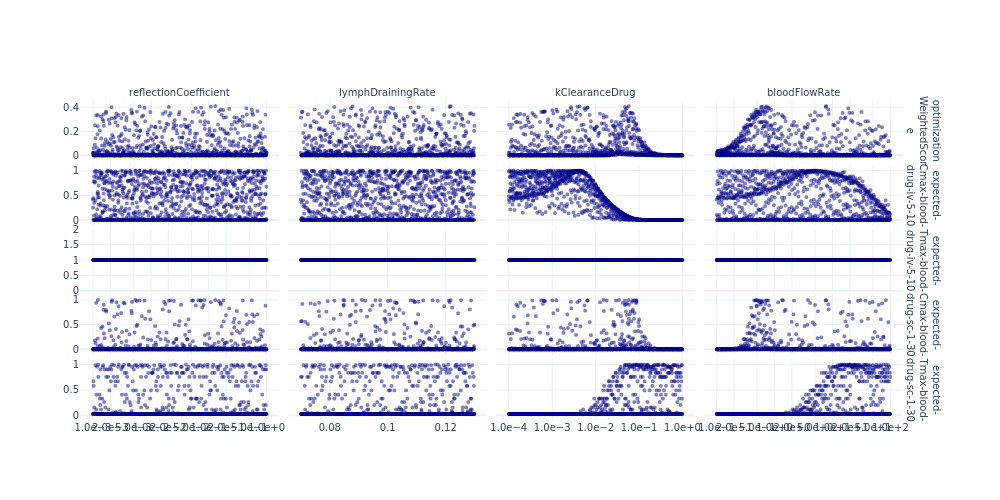

In [52]:
figureHeight = 500
figureWidth = 1000

scoreList = list(dfFull.score.unique())
scoreList.remove("optimizationWeightedScore")
scoreList = [
    "optimizationWeightedScore"
] + scoreList  # comment this line to plot only "optimizationWeightedScore"
nbScores = len(scoreList)

scoreListWrapped = ["<br>".join(textwrap.wrap(t, width=12)) for t in scoreList]

nbParams = len(parameters)
parametersWrapped = [
    "<br>".join(textwrap.wrap(parameter["id"], width=30)) for parameter in parameters
]

# Add here all params that should be displayed using a log scale
# By default, all params that had a custom range in log are selected
logParams = [p for p in custom_range if custom_range[p]["logscale"] == True]

fig = make_subplots(
    len(scoreList),
    len(parameters),
    shared_xaxes=True,
    shared_yaxes=True,
    horizontal_spacing=0.01,
    vertical_spacing=0.01,
    column_titles=parametersWrapped,
    row_titles=scoreListWrapped,
)
for i in range(nbScores):
    for j in range(nbParams):
        scatter_df = dfFull.loc[
            (dfFull["parameterName"] == parameters[j]["id"])
            & (dfFull["score"] == scoreList[i])
        ]
        fig.add_trace(
            go.Scatter(
                x=scatter_df["parameterValue"],
                y=scatter_df["likelihoodTrans"],
                mode="markers",
                marker=dict(size=4, color="darkblue", opacity=0.5),
                hoverinfo="none",
            ),
            row=i + 1,
            col=j + 1,
        )

        if parameters[j]["id"] in logParams:
            fig.update_xaxes(type="log", row=i + 1, col=j + 1, tickformat=".1e")
fig.update_annotations(font_size=10)
fig.update_layout(
    font=dict(size=10),
    showlegend=False,
    width=figureWidth,
    height=figureHeight,
    template="plotly_white",
)
fig.show(renderer="jpeg")

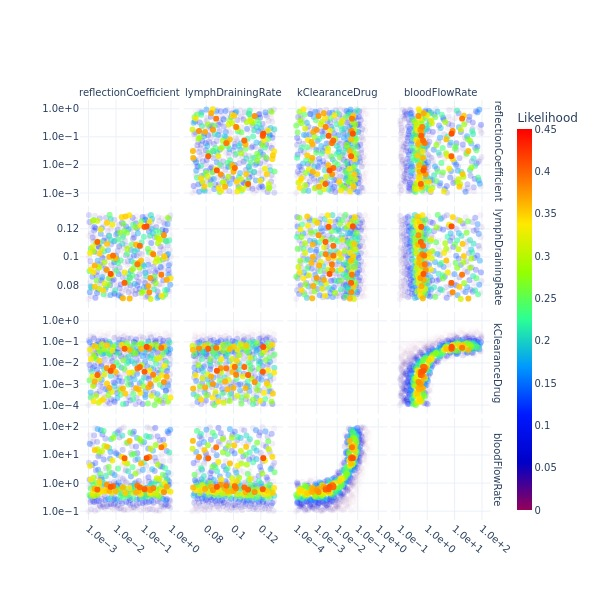

In [51]:
# Add here all params that should be displayed using a log scale
# By default, all params that had a custom range in log are selected
logParams = [p for p in custom_range if custom_range[p]["logscale"] == True]

figureHeight = 600
figureWidth = 600

fig = make_subplots(
    len(parameters),
    len(parameters),
    shared_xaxes=True,
    shared_yaxes=True,
    horizontal_spacing=0.01,
    vertical_spacing=0.01,
    column_titles=parametersWrapped,
    row_titles=parametersWrapped,
)
for i in range(nbParams):  # iterating over rows
    for j in range(nbParams):  # iterating over columns
        if i == j:  # do not plot anything on the diagonal
            fig.add_trace(
                go.Scatter(x=[], y=[]),
                row=i + 1,
                col=j + 1,
            )
        else:
            df_j = dfFull.loc[
                (dfFull["parameterName"] == parameters[j]["id"])
                & (dfFull["score"] == "optimizationWeightedScore")
            ]
            df_j = df_j[["parameterValue", "likelihoodTrans", "patientId"]].rename(
                columns={"parameterValue": parameters[j]["id"]}
            )
            df_i = dfFull.loc[
                (dfFull["parameterName"] == parameters[i]["id"])
                & (dfFull["score"] == "optimizationWeightedScore")
            ]
            df_i = df_i[["parameterValue", "patientId"]].rename(
                columns={"parameterValue": parameters[i]["id"]}
            )

            scatter_df = df_j.merge(df_i, how="inner", on=["patientId"])
            scatter_df = scatter_df.sort_values(by="likelihoodTrans")
            fig.add_trace(
                go.Scatter(
                    x=scatter_df[parameters[j]["id"]],  # x axis is the column parameter
                    y=scatter_df[parameters[i]["id"]],  # y axis is the row parameter
                    mode="markers",
                    marker=dict(
                        size=6,
                        color=scatter_df["likelihoodTrans"],
                        opacity=(
                            scatter_df["likelihoodTrans"]
                            / scatter_df["likelihoodTrans"].max()
                        ),
                        coloraxis="coloraxis1",
                    ),
                    hoverinfo="none",
                ),
                row=i + 1,
                col=j + 1,
            )

        # Set the log scale for x and / or y axes
        if parameters[j]["id"] in logParams:
            fig.update_xaxes(type="log", row=i + 1, col=j + 1, tickformat=".1e")
        if parameters[i]["id"] in logParams:
            fig.update_yaxes(type="log", row=i + 1, col=j + 1, tickformat=".1e")
fig.update_annotations(font_size=10)
fig.update_xaxes(tickangle=40)
fig.update_coloraxes(
    colorbar_title="Likelihood",
    cmin=0,
    cmax=0.45,
    colorscale="Rainbow",
    colorbar_thickness=15,
)
fig.update_layout(
    font=dict(size=10),
    showlegend=False,
    width=figureWidth,
    height=figureHeight,
    template="plotly_white",
)
fig.show(renderer="jpeg")